# Unstructured Data Analytics HW2

Name:Bochen Wang

Andrew ID:bochenw

Collaborators (if none, say "none"; do *not* leave this blank):I consulted chatgpt

Reminder: you should not be sharing code.

## Question 1: Clustering emails using Gaussian Mixture Models [50 pts]

For this problem, we will be analyzing emails taken from the [Enron Email Dataset](https://www.cs.cmu.edu/~enron/). We have already curated the data for you in the `data/enron` directory, with one file per email (so there is no need to redownload the dataset as it is already included in this homework zip archive). The dataset includes a combination of "spam" and "ham" emails. Spam emails are unsolicited messages intended to sell a product or scam users into providing personal information, while ham emails represent everything that is not spam.

The language used in spam emails tends to be considerably different from typical business emails. Most spam filters leverage this difference in word frequencies to detect spam as it arrives and filter it out of email inboxes. We will use Gaussian Mixture Models (GMMs) to cluster the emails and attempt to identify groups of emails which are likely to be spam.

### Part A: Construct a list of processed documents [10 points]

Provided below is a function that returns a document present in a file given a filename. The function performs some preprocessing to (1) remove punctuation, (2),(3) remove whitespace and (4) lowercase all words. Using the `make_word_list` function, construct a list of processed documents.

In [1]:
import re
import string
import codecs

def make_word_list(path):
    
    with codecs.open(path, "r", encoding='utf-8', errors='ignore') as f:
        corpus_text = f.read()

    for c in string.punctuation:
        corpus_text = corpus_text.replace(c, "")  # -- (1)
    
    text = re.sub(r'\S*\d\S*', '', corpus_text) # -- (2)
    text = re.sub(r'[^\w\s]', '', text)         # -- (3)
    
    text = text.lower().split()           # -- (4)         
    
    li = []
    for token in text:
        li.append(token)

    return " ".join(li)

In [2]:
########################################################################
######################### Write your code here #########################
########################################################################
import glob
path = './data/enron/*.txt'
word_list = []
for filename in glob.glob(path):
    word_list.append(make_word_list(filename))


### Part B: Construct a document matrix [10 points]

Next, construct a document matrix `X` as a matrix of [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) features for each document. TF-IDF features encode information about the word frequency within a document, weighted by the frequency of the same word for corpus as a whole.

   - Use the `TfidfVectorizer` from [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) to create the document matrix `X`.
   - Set `min_df=50`; this drops words that don't occur in at least 50 documents.
   - Set `stop_words="english"` and `max_df=0.8` to filter out stop-words.
   - Print the number of unique words in the vocabulary Hint: Look for the `vocabulary_` attribute in the `TfidfVectorizer` object after fitting the vectorizer to the data set. The vocabulary will also be needed in part (d).

In [3]:
########################################################################
######################### Write your code here #########################
########################################################################
# vocab_size = 1000
# from sklearn.feature_extraction.text import CountVectorizer

# # CountVectorizer does tokenization and can remove terms that occur too frequently, not frequently enough, or that are stop words

# # document frequency (df) means number of documents a word appears in
# tf_vectorizer = CountVectorizer(max_df=0.95,
#                                 min_df=2,
#                                 stop_words='english',
#                                 max_features=vocab_size)
# tf = tf_vectorizer.fit_transform(data)

from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TfidfVectorizer with the specified parameters
vectorizer = TfidfVectorizer(min_df=50, 
                             max_df=0.8, 
                             stop_words='english')

# Fit the vectorizer to the documents and transform the documents into a document-term matrix
X = vectorizer.fit_transform(word_list)

# Print the number of unique words in the vocabulary
vocabulary_size = len(vectorizer.vocabulary_)
vocabulary_size


1680

### Part C: Perform Clustering [10 points]

Perform clustering on the document matrix `X` using GMMs. 
- Use the `GaussianMixture` module from [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html) to cluster the documents.
- Set the number of clusters (mixture components) to 3.
- Print the number of documents assigned to each cluster.

In [4]:
pip install --upgrade threadpoolctl 

Note: you may need to restart the kernel to use updated packages.


In [5]:
########################################################################
######################### Write your code here #########################
########################################################################

from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3, n_init=1, random_state=0)
X_array = X.toarray()
gmm_cluster_assignments = gmm.fit_predict(X_array)
cluster_counts = [list(gmm_cluster_assignments).count(i) for i in range(3)]
cluster_counts

[4478, 365, 328]

### Part D: Characterize the clusters [10 points]

Now, we will attempt to characterize the clusters based on the frequency of spam-relevant words. 
- Select 3 "spammy" words from the vocabulary that you expect to occur frequently in spam emails and less frequently in normal business emails (e.g., 'click', 'www', 'offer'). Construct a list, `spam_indices`, storing the indices of the spammy words you selected in the vocabulary generated by `TfidfVectorizer`.
- Select 3 "hammy" words from the vocabulary you think will occur frequently in business emails and infrequently in spam emails (e.g., 'meeting', 'attached', 'review'). Construct a list, `ham_indices`, storing the indices of the hammy words you selected in the vocabulary generated by `TfidfVectorizer`.
- Use the function provided below, `plot_spam_words_by_cluster`, to plot the average TF-IDF features for your selected spammy words and hammy words for each cluster. The function takes the following parameters:
    - `X` is a matrix of TF-IDF features (rows index documents, columns index terms).
    - `predicted` is predicted cluster assignments returned by `GaussianMixture.predict()`
    - `n_clusters` is the number of clusters. This should match the number of clusters from your GMM.
    - `spam_indices` is a list of indices of spammy words in the vocabulary.
    - `ham_indices` is a list of indices of hammy (typical business) words in the vocabulary.

In [6]:
def plot_spam_words_by_cluster(X, predicted, n_clusters, spam_indices, ham_indices):
    import numpy as np
    import matplotlib.pyplot as plt
    
    # Calculate mean TF-IDF features for each cluster
    mean_tfidf_spam = []
    mean_tfidf_ham = []
    for spam in spam_indices:
        mean_tfidf_spam.append([])
    for ham in ham_indices:
        mean_tfidf_ham.append([])
    
    for i in range(n_clusters):
        for j, spam_idx in enumerate(spam_indices):
            mean_tfidf_spam[j].append(X[predicted==i, spam_idx].mean())
        for j, ham_idx in enumerate(ham_indices):
            mean_tfidf_ham[j].append(X[predicted==i, ham_idx].mean())
    
    # Generate plot
    fig, ax = plt.subplots()

    ind = np.arange(n_clusters)    # the x locations for the groups
    width = 0.10         # the width of the bars

    # Plot spam bars
    for i, val in enumerate(mean_tfidf_spam):
        spam_bar = ax.bar(ind - (len(mean_tfidf_spam)-i-1)*width, val, width, color='r', bottom=0)

    # Plot ham bars
    for i, val in enumerate(mean_tfidf_ham):
        ham_bar = ax.bar(ind + (len(mean_tfidf_ham)-i)*width, val, width,
                color='y', bottom=0)

    ax.set_title('Mean TF-IDF Features by Cluster for Spam-Relevant Words')
    ax.set_xticks(ind + width / 2)
    xticklabels = []
    for i in range(n_clusters):
        xticklabels.append('Cluster ' + str(i) + '\n(n=' + str((predicted==i).sum()) + ')')
    ax.set_xticklabels(xticklabels)

    ax.legend((spam_bar[0], ham_bar[0]), ('Spammy words', 'Hammy words'))
    ax.autoscale_view()
    ax.set_ylabel('Mean TF-IDF')
    plt.show()

In [7]:
########################################################################
######################### Write your code here #########################
########################################################################
from collections import Counter
vocabulary = vectorizer.vocabulary_
for k, v in Counter(vocabulary).most_common(50):
    print('%s: %i' % (k, v))

young: 1679
york: 1678
yesterday: 1677
yes: 1676
years: 1675
year: 1674
yahoo: 1673
xp: 1672
xara: 1671
www: 1670
wrong: 1669
writing: 1668
write: 1667
worth: 1666
worldwide: 1665
world: 1664
works: 1663
working: 1662
worked: 1661
work: 1660
words: 1659
word: 1658
won: 1657
women: 1656
woman: 1655
wish: 1654
winning: 1653
windows: 1652
win: 1651
wilson: 1650
willing: 1649
wili: 1648
wiil: 1647
wiii: 1646
wife: 1645
wide: 1644
wi: 1643
wholesale: 1642
white: 1641
west: 1640
went: 1639
welcome: 1638
weight: 1637
weeks: 1636
weekly: 1635
week: 1634
wednesday: 1633
websites: 1632
website: 1631
web: 1630


In [8]:
vectorizer.vocabulary_['review']

1283

In [9]:
spammy_words = ['www', 'websites', 'worth'] 
hammy_words = ['review', 'meeting', 'attached']  

spam_indices = [vocabulary[word] for word in spammy_words]
ham_indices = [vocabulary[word] for word in hammy_words]


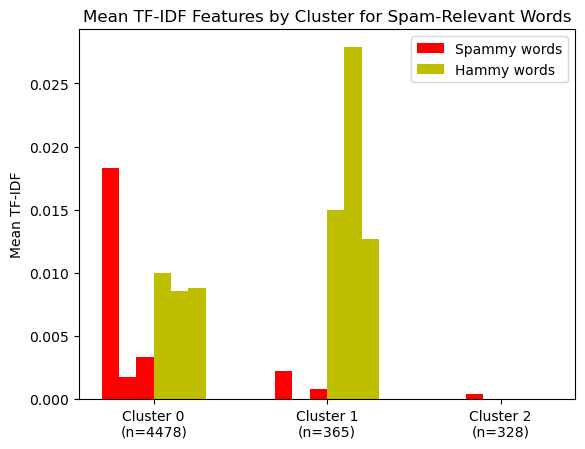

In [10]:
plot_spam_words_by_cluster(X,gmm_cluster_assignments,3, spam_indices, ham_indices )

### Part E: Interpret results [10 points]

From the plot generated in part (d), do any of the clusters correspond to spam emails, based on the frequency of spammy and hammy words? Do any of the clusters appear to correspond to typical business emails (ham)? 

Re-run your analysis with a different choice for the number of clusters in your GMM (e.g., `n_clusters=5` or `n_clusters=2`). How does changing the number of clusters affect your results? Does one choice of `n_clusters` appear better than another for locating clusters of spam emails?

*** WRITE YOUR ANSWER HERE IN TEXT ***

Yes, the cluster 0 respond to the spammy words which has high volumn of the spammy words. 

Cluster 1 reulsts in the hammpy words. Some hammy words appears in the spammy clusters. This can be a result of the word chosen is fairly used on daily English conversations.

In [12]:
########################################################################
######################### Write your code here #########################
########################################################################
from sklearn.mixture import GaussianMixture

gmm2 = GaussianMixture(n_components=5, n_init=1, random_state=0)
gmm_cluster_assignments2 = gmm2.fit_predict(X_array)
# cluster_counts = [list(gmm_cluster_assignments).count(i) for i in range(3)]
# cluster_counts


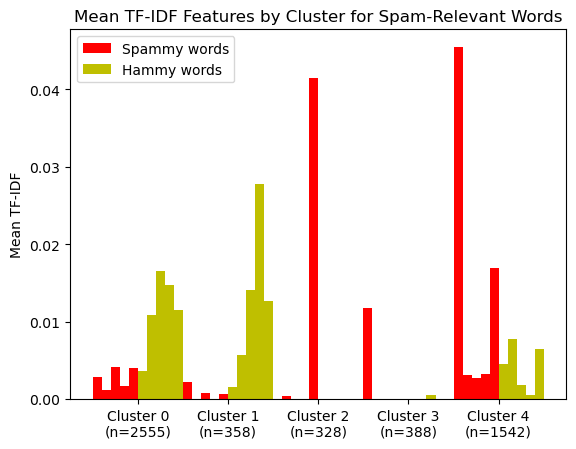

In [13]:
spammy_words2 = ['www', 'websites', 'worth', 'win', 'web'] 
hammy_words2 = ['review', 'meeting', 'attached', 'year', 'yes']  

spam_indices2 = [vocabulary[word] for word in spammy_words2]
ham_indices2 = [vocabulary[word] for word in hammy_words2]

plot_spam_words_by_cluster(X,gmm_cluster_assignments2,5, spam_indices2, ham_indices2 )

The number of clusters change can actually imporve the porfomance on tellling the difference for the different clusters. They have a clear disctinction in the distribution. n_clusters did influenced the better locating the spammy words.

## Question 2: Latent "Purposes" in Mobile Apps [45 points]


Think of Android applications as "documents", where "words" are the "permissions" that each app requests. Each app has a set of latent "purposes" (topics); a "purpose" may be a specific task (such as taking photographs and uploading them to the internet), and an application may have a mixture of purposes of varying strength.

Can we uncover these purposes from a dataset of Android applications and the permissions they request?

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

### Part A: Load the data [0 points]

The [dataset](http://www.mariofrank.net/andrApps/) contains ~180,000 applications from the Android app store, including each app's name, description and permissions requested. For more about Android app permissions, see [this report](http://www.pewinternet.org/2015/11/10/an-analysis-of-android-app-permissions/).

   * Download the data and unzip it into the same folder as this notebook.
   * Rename the CSV file to "android.csv".
   * Run the cells below to load the data into the notebook.

This may take up ~2GB of RAM.

In [15]:
df = pd.read_csv("android.csv", sep=",",  thousands=",")

In [16]:
df["Number of ratings"] = df["Number of ratings"].astype(int) # fix data type
df = df.drop_duplicates(subset=["App"]).reset_index(drop=True)

In [17]:
df.head(n=3)

,App,Package,Category,Description,Rating,Number of ratings,Price,Related apps,Dangerous permissions count,Safe permissions count,...,Your personal information : read Browser's history and bookmarks (D),Your personal information : read calendar events (D),Your personal information : read contact data (D),Your personal information : read sensitive log data (D),Your personal information : read user defined dictionary (D),Your personal information : retrieve system internal state (S),Your personal information : set alarm in alarm clock (S),Your personal information : write Browser's history and bookmarks (D),Your personal information : write contact data (D),Your personal information : write to user defined dictionary (S)
0,Google Maps,com.google.android.apps.maps,Travel & Local,"Download the latest release of Google Maps, an...",4.4,1438259,$0.00,"{com.jsdfproductions.ctatrackerpro, com.alk.co...",17.0,8,...,0,0,1,0,0,0,0,0,1,0
1,Snowfall Live Wallpaper,fishnoodle.snowfall_free,Personalization,Snowfall Live Wallpaper: Wintertime on your ho...,4.3,18147,$0.00,"{colfore.wallpaper.snowfree, com.tabsoft.wallp...",0.0,0,...,0,0,0,0,0,0,0,0,0,0
2,Aquarium Live Wallpaper,fishnoodle.aquarium_free,Personalization,A beautiful tropical fish tank live wallpaper!...,4.1,62145,$0.00,"{com.convisual.lwp.fishometerlite, com.accessl...",0.0,0,...,0,0,0,0,0,0,0,0,0,0


### Part B: Convert each app into a "document" [0 points]

The code below does the following:

   * Filter out all the columns except the permission columns.
   * Convert this dataframe into a numpy matrix.

There are thus 180295 apps (documents) and 173 permissions (words).

   - `X` is the "document" or "word-frequency" matrix.
   - `permission_columns` contains the words ordered by their column index in X.
   - `app_names` contains the application names ordered by their row index in X.
   - `app_ratings` contains the *number* of application ratings (not the ratings themselves).

In [18]:
permission_columns = list(df.columns[10:])
app_names = list(df["App"])
app_ratings = np.array(df["Number of ratings"])
df_perms = df[permission_columns]
X = df_perms.values
del df # uncomment to free up RAM
del df_perms # uncomment to free up RAM

In [109]:
jj = 0
for i in range(len(app_ratings)):
    if app_ratings[i] > 100000:
        jj +=1

print(jj)

95


### Part C: Downweight "stopwords" [2.5 points]

There are some permissions requested by almost all applications (like "INTERNET"), they are similar to stop-words ("the", "and", etc.) in natural language. We can downweight them by TF-IDF normalization.

   * Use the `TfidfTransformer` class in `scikit-learn` to transform X.

In [19]:
########################################################################
######################### Write your code here #########################
########################################################################
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()

X_tfidf = tfidf_transformer.fit_transform(X)

In [59]:
X_tfidf.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.18350514,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

### Part D: Discover 10 "topics" [2.5 points]

   * Use the `LatentDirichletAllocation` class in `scikit-learn` to fit 10 topics to the data.
   * Use 10 max iterations, set `n_jobs=-1` to use all cores on your machine (if it helps).
   * Feel free to understand and play around with other parameters.
   * This may take around 3 minutes to run.

In [65]:
%%time
########################################################################
######################### Write your code here #########################
########################################################################
num_topics = 10

from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=num_topics,max_iter=10,n_jobs=-1, random_state=0)
lda.fit(X_tfidf)

CPU times: user 2 s, sys: 139 ms, total: 2.14 s
Wall time: 10.7 s


LatentDirichletAllocation(n_jobs=-1, random_state=0)

Now each app can be viewed as a distribution over these 10 topics, and each topic is a distribution over all the permissions in the data.

### Part E: List the top 10 "words" in each topic [15 points]

Do any of the topics correspond to meaningful app "purposes"? List the ones you find meaningful below:

   * Topic #i: "your interpretation"

In [66]:
topic_word_distributions = np.array([row / row.sum() for row in lda.components_])

In [67]:
topic_word_distributions.shape


(10, 173)

In [68]:
########################################################################
######################### Write your code here #########################
########################################################################

# here I used the code from lecture demo only changing and adding the permission's names inside the functions since 
# we are only getting the value of distribution in the permissions.
num_top_words = 10

def print_top_words(topic_word_distributions, num_top_words, vectorizer):
    vocab = vectorizer.get_feature_names_out()
    num_topics = len(topic_word_distributions)
    print('Displaying the top %d words per topic and their probabilities within the topic...' % num_top_words)
    print()

    for topic_idx in range(num_topics):
        print('[Topic ', topic_idx, ']', sep='')
        sort_indices = np.argsort(-topic_word_distributions[topic_idx])
        for rank in range(num_top_words):
            word_idx = sort_indices[rank]
            print(permission_columns[word_idx], ':',
                  topic_word_distributions[topic_idx, word_idx])
        print()

print_top_words(topic_word_distributions, num_top_words, tfidf_transformer)

Displaying the top 10 words per topic and their probabilities within the topic...

[Topic 0]
Your location : coarse (network-based) location (D) : 0.25644949994911365
Your location : fine (GPS) location (D) : 0.24650468420432847
Network communication : full Internet access (D) : 0.1542150017602115
Network communication : view network state (S) : 0.10148873290783791
Phone calls : read phone state and identity (D) : 0.08057643744231588
Storage : modify/delete USB storage contents modify/delete SD card contents (D) : 0.06369555562003526
Services that cost you money : directly call phone numbers (D) : 0.05193934584426721
Your personal information : read sensitive log data (D) : 0.021990441913125703
Network communication : view Wi-Fi state (S) : 0.019562355914579662
Default : access checkin properties (S) : 0.0009866530013707693

[Topic 1]
Hardware controls : control vibrator (S) : 0.44428245980772507
Network communication : full Internet access (D) : 0.14349279845405583
Network communicati

*** WRITE YOUR ANSWER HERE IN TEXT ***

topic 0 can be some map applications
topic 1 I am not sure
topic 2 can be some text app
topic 4 can be some settings
topic 5 can be some wallpaper tools

we can still see some interesting topics here differ from one another still there are some unknown topics. Afterall, these are just their permissions.

### Part F: For each topic, list the top 3 apps with at least 100000 ratings having the highest probability assigned to that topic [15 points]

   - This further helps us understand what the topics actually mean.
   - However, the data is noisy and this exercise may result in listing a bunch of obscure apps.
   - Hence, filtering out all apps with less than 100000 ratings may help.

In [69]:
########################################################################
######################### Write your code here #########################
########################################################################
doc_topic_matrix = lda.transform(X_tfidf)

In [70]:
doc_topic_matrix.shape


(180295, 10)

In [110]:
rating_over_100k = [] #get the indexes of rating over 100k
for i in range(len(app_ratings)):
    if app_ratings[i] > 100000:
        rating_over_100k.append(i)

In [113]:
topic_matrix_100k = doc_topic_matrix[rating_over_100k,] #selecting the indexes over 100k

In [117]:
topic_matrix_100k.shape

(95, 10)

In [118]:
df_2f = pd.DataFrame(topic_matrix_100k, columns = range(10))#convert into df

In [119]:
df_2f

,0,1,2,3,4,5,6,7,8,9
0,0.018412,0.018412,0.018407,0.706895,0.018412,0.018407,0.018412,0.145805,0.018415,0.018423
1,0.019843,0.019846,0.019843,0.509748,0.019845,0.019843,0.019843,0.019842,0.019845,0.331501
2,0.023667,0.023668,0.023668,0.023677,0.023691,0.023667,0.023674,0.548941,0.207133,0.078214
3,0.028328,0.028329,0.028335,0.319624,0.028328,0.201944,0.028328,0.028328,0.028327,0.280128
4,0.297006,0.033243,0.033252,0.033250,0.033254,0.033244,0.033244,0.033244,0.437016,0.033248
...,...,...,...,...,...,...,...,...,...,...
90,0.023667,0.023668,0.023668,0.023677,0.023691,0.023667,0.023674,0.548941,0.207133,0.078214
91,0.022719,0.022714,0.022711,0.369185,0.022720,0.082704,0.389110,0.022715,0.022711,0.022710
92,0.026397,0.026390,0.026393,0.026389,0.026403,0.026392,0.762465,0.026392,0.026392,0.026389
93,0.017476,0.017481,0.017476,0.246205,0.017483,0.017572,0.017475,0.017479,0.017481,0.613871


In [170]:
for topic_idx in range(10):
    j = 0
    print('[Topic ', topic_idx, ']', sep='')
    result = df_2f[topic_idx].argsort()[::-1]#get the result of sorted values in a topic column
    while(j != 3):
        print(app_names[rating_over_100k[result[94 - j]]]) #print the top 3 related topics
        j +=1
            
    print()

[Topic 0]
Dictionary.com
Air Control Lite
Paper Toss

[Topic 1]
Live Holdem Poker Pro
Vaulty Free Hides Pictures
Drag Racing

[Topic 2]
Angry Birds Seasons
Yoo Ninja! Free
Adobe Reader

[Topic 3]
Lookout Security & Antivirus
Antivirus Free
Skype

[Topic 4]
Real BlackJack
Alchemy
Tank Hero

[Topic 5]
World Newspapers
Paradise Island
My Country

[Topic 6]
Brightest Flashlight Free™
Brightest Flashlight Free???
Tiny Flashlight + LED

[Topic 7]
Slice It!
Racing Moto
Blast Monkeys

[Topic 8]
TuneIn Radio
Restaurant Story™
Restaurant Story???

[Topic 9]
chompSMS
Ringdroid
Google Sky Map



### Part G: Visualize the document-topic proportion matrix in 2-D using t-SNE [10 points]

Does our reduced dimensional space contain any structure? Visualize the documents (in the topic-space) using t-SNE.

   * Use `TSNE` from `scikit-learn`.
   * Set the angle to 0.99 and init to 'PCA'. Pick any learning rate that gives you a visually pleasing result.
   * You may `fit` TSNE to a sample of the data (>1000 documents) instead of the full data.
   * Remember to call `fit_transform` to obtain your 2-D data.
   * Plot the t-SNE dimensions as a scatterplot.
   * Color each point based on its most probable topic. Make sure you include a legend (10 colors).
   
Clusters in the t-SNE plot indicate groups of apps that have similar topics.

In [211]:
labels = 

(10, 173)

In [213]:
np.random.seed(0)
X_sample = np.random.permutation(doc_topic_matrix)[:2000]

In [214]:
X_sample.shape

(2000, 10)

In [227]:
labels = np.argmax(X_sample, axis=1)

In [216]:
%%time
########################################################################
######################### Write your code here #########################
########################################################################


from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


# *WARNING*: *despite* what the sklearn documentation says for t-SNE, the perplexity parameter
# does matter! a helpful article to read: https://distill.pub/2016/misread-tsne/
tsne = TSNE(n_components=2, perplexity=5,learning_rate=0.1, n_iter=1000, init='pca', verbose=1, random_state=0,angle=0.99)
swiss_roll_tsne = tsne.fit_transform(X_sample)



[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.002s...
[t-SNE] Computed neighbors for 2000 samples in 0.021s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 89.217148
[t-SNE] KL divergence after 1000 iterations: 1.823456
CPU times: user 10.2 s, sys: 2.88 s, total: 13 s
Wall time: 1.79 s


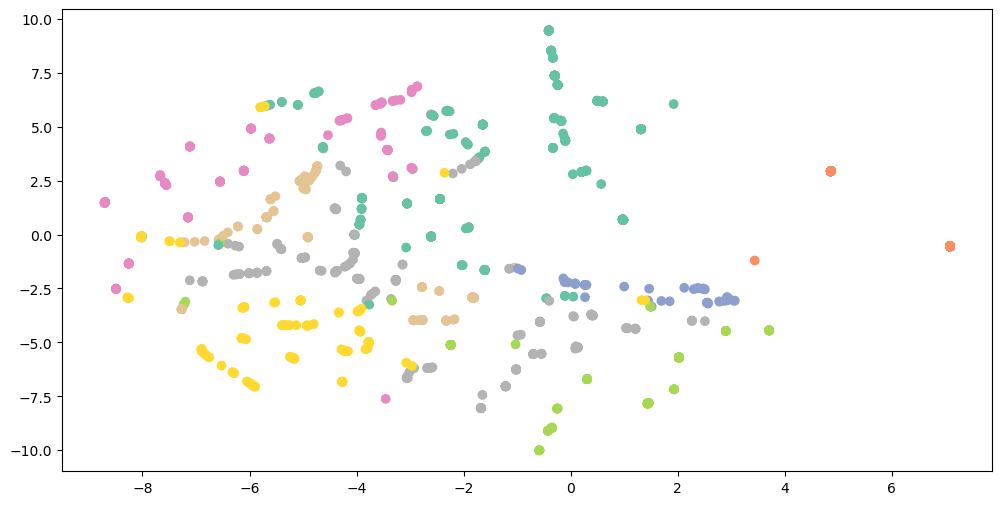

In [236]:
plt.figure(figsize=(12, 6))
plt.scatter(swiss_roll_tsne[:,0], swiss_roll_tsne[:,1], c=labels, cmap='Set2')

## Question 3: Questionnaire [5 points]

Please answer this survey after you have done this homework: https://forms.gle/8i5htD6oXMr1nK958